## Import the necessary libraries

In [23]:
import sys

from scipy.optimize import curve_fit

sys.path.append("../../src")

from relaxnmr.core import T1Functions

import numpy as np

import matplotlib.pyplot as plt

## specify path to the data file and ensure that "\\\\" is appended to the end of the path

 - create an instance t1 of T1Functions

In [24]:
filepath = r"..\..\data\T2_cpmg_data\38\\"

t1 = T1Functions(filepath)

## Read and convert Bruker NMR data to NMRPipe and CSDM formats: read_and_convert_bruker_data.

The function automatically detects and loads the variable delay list (vdlist, vplist, vclist) used in the experiment. In this case, the vclist is loaded, but vdlist terminology will be used.

 - Note: the vclist contains the variable count and needs to be converted to time delay -- this will be explained in a later stage.

It returns a tuple containing three elements: a list of 1D NMR (spectra), the variable delay list (vd_list), and the complete dataset in CSDM format (csdm_ds)

In [25]:
spectra, vd_list, csdm_ds = t1.read_and_convert_bruker_data(filepath)

## Process the returned 1D NMR spectra
 - apply the Gaussian apodisation (fwhm)
 - zero-filling for increased digital resolution (zero_fill_factor)
 - 0th order phase correction (ph0)
 - 1st order phase correction (ph1) -- this phase correction is a bit nuanced and so far, a value of 0 - 0.6 ° has worked quite well: see the "Understanding Phasing" example under User Guide
 - In applying the 1st order correction, you would have to experiment with the mentioned values to obtain a pure absorption line-shape signal

In [26]:
exp_spectra = []
for i, spectrum in enumerate(spectra):
    
    if i == 0:
        exp_spectrum = t1.process_spectrum(spectrum, fwhm="50 Hz", zero_fill_factor=10, ph0=285, ph1=0.195)
        exp_spectra.append(exp_spectrum)
    elif i == 1:
        exp_spectrum = t1.process_spectrum(spectrum, fwhm="50 Hz", zero_fill_factor=10, ph0=295, ph1=0.1948)
        exp_spectra.append(exp_spectrum)
    elif i == 2:
        exp_spectrum = t1.process_spectrum(spectrum, fwhm="50 Hz", zero_fill_factor=10, ph0=290, ph1=0.1948)
        exp_spectra.append(exp_spectrum)
    elif i == 3:
        exp_spectrum = t1.process_spectrum(spectrum, fwhm="50 Hz", zero_fill_factor=10, ph0=285, ph1=0.195)
        exp_spectra.append(exp_spectrum)
    elif i == 4:
        exp_spectrum = t1.process_spectrum(spectrum, fwhm="50 Hz", zero_fill_factor=10, ph0=280, ph1=0.195)
        exp_spectra.append(exp_spectrum)
    elif i == 5:
        exp_spectrum = t1.process_spectrum(spectrum, fwhm="50 Hz", zero_fill_factor=10, ph0=280, ph1=0.1948)
        exp_spectra.append(exp_spectrum)
    elif i == 6:
        exp_spectrum = t1.process_spectrum(spectrum, fwhm="50 Hz", zero_fill_factor=10, ph0=290, ph1=0.1948)
        exp_spectra.append(exp_spectrum)
    elif i == 7:
        exp_spectrum = t1.process_spectrum(spectrum, fwhm="50 Hz", zero_fill_factor=10, ph0=290, ph1=0.195)
        exp_spectra.append(exp_spectrum)
    else :
        exp_spectrum = t1.process_spectrum(spectrum, fwhm="50 Hz", zero_fill_factor=10, ph0=292, ph1=0.1948)
        exp_spectra.append(exp_spectrum)

## Find the area under the peak of interest using the ``integrate_spectrum_region()`` function
The integration function employed here integrate each spectrum using trapezoid and simpson function, respectively.
ppm_start and ppm_end need to be defined as the starting and ending ppm region needed to be integrated. 
The integrated area of each spectrum is appended to trapz_ints and simps_ints, respectively.
x_ and y_regions are regions of integration in the spectra -- needed for visuals.


 - There is no difference between trapz and simps, so you would have to use either of the two in a later stage

In [27]:
trapz_ints = []
simps_ints = []
x_regions = []
y_regions = []
int_uncs = []
for i, exp_spectrum in enumerate(exp_spectra):
    trapz_int, simps_int, x_region, y_region, int_unc = t1.integrate_spectrum_region(exp_spectrum, 
                                                                                     ppm_start=-15, ppm_end=15)
    trapz_ints.append(trapz_int)
    simps_ints.append(simps_int)
    x_regions.append(x_region)
    y_regions.append(y_region)
    int_uncs.append(int_unc)

## plot_spectra_and_zoom() function
 - creates plots of NMR spectra with both full view and zoomed regions (max and min x zoom)
 - highlights the integrated x_ and y_regions on the zoomed plot
 - returns maximum intensities from each spectrum (abs_ints): relevant for relaxometry just like integrated areas contained in trapz_ints and simps_ints

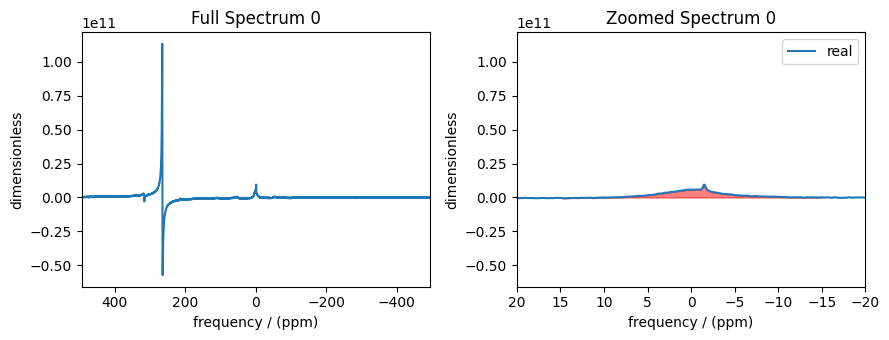

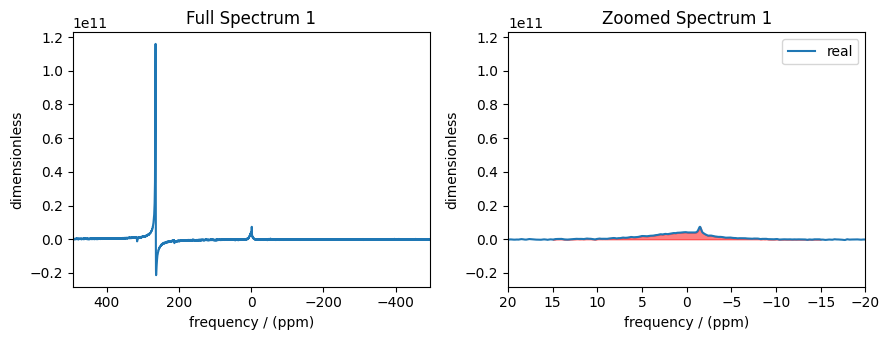

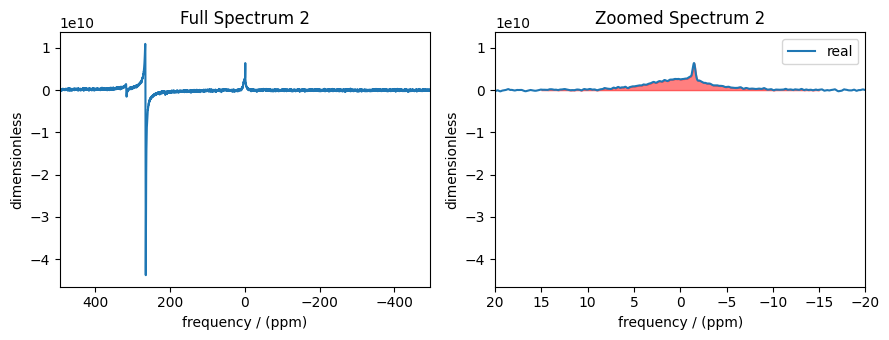

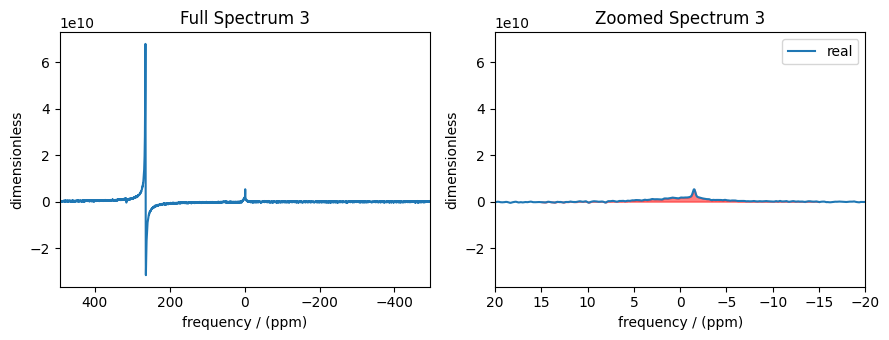

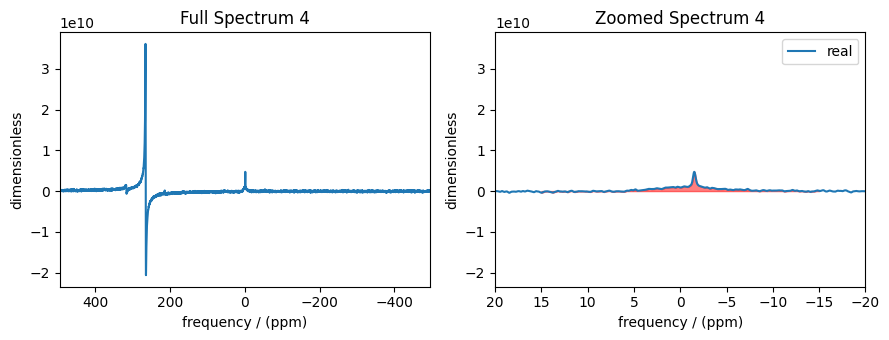

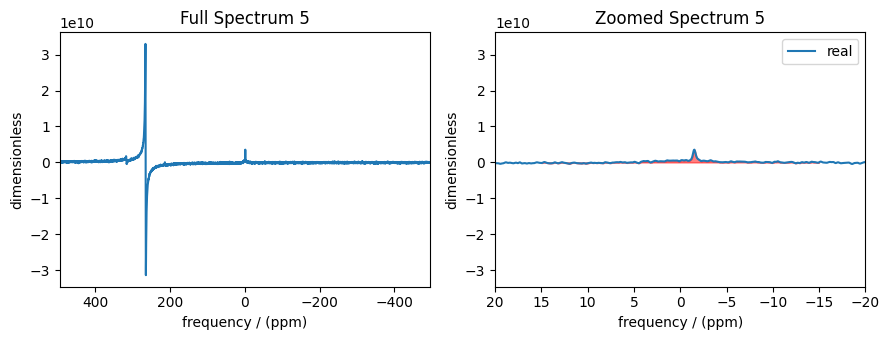

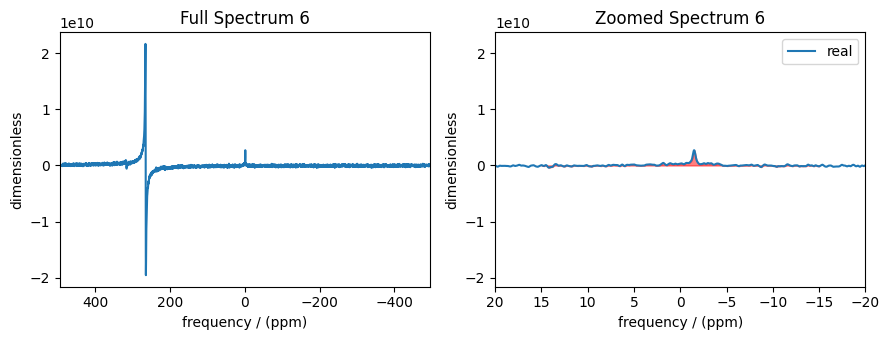

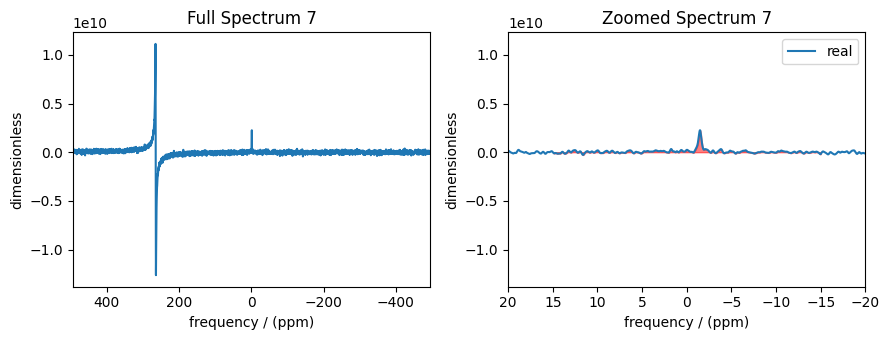

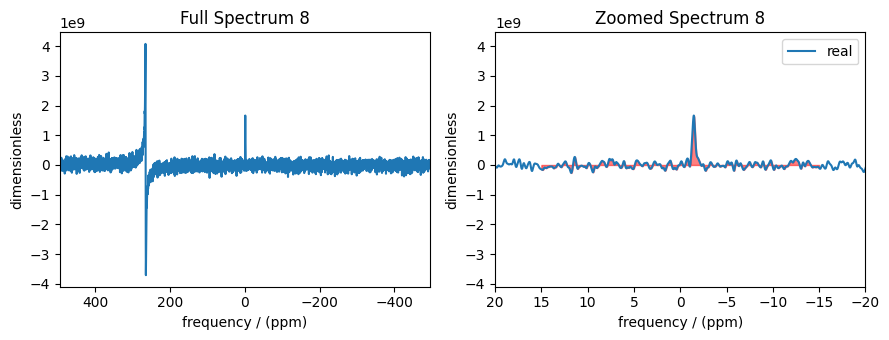

In [28]:
max_x_zoom = 20

min_x_zoom = -20

abs_ints = t1.plot_spectra_and_zoomed_regions(exp_spectra, x_regions, y_regions, max_x_zoom, min_x_zoom)

## Convert vd list to numpy array and ensure that the list and extracted intensities and areas are of the same length

- The variable count list (n) imported from the file_path is converted to a numpy array
- The conversion factor 2 x D2 is applied to convert counts to time (seconds)
- where [D2 - π - D2]<sub>n</sub> is used for this conversion
    - 4.86 μs delay i.e. D2 is used in the experiment and n corresponds to the variable count list containerised in the vdlist variable
- To ensure consistency, the simps_ints and abs_ints are sliced to match the length of vd_list, since sometimes the experiment is stopped when the NMR user observes that the system has completely relaxed 

<img src="https://blogger.googleusercontent.com/img/b/R29vZ2xl/AVvXsEjQkaB3EdJ_XRXExXj_XvNzW7n3G_cdc-YcR2izMnsMOjxK9sk6FI7jHBNX6piIVjcQ3VY8Tco2XborpZ78D-0qVrkqMdBLgtkszhTts5qARkTAYouk-U7niac11OFmBxymeH2iQSwMjdE/s400/cpmg2.jpg"/>

Note, D2 is labelled D20 in Bruker.

In [29]:
# Enter your D2 or D20 value in the variable D2

D2 = 4.86e-6

#vd_list imported from the file_path and converted into a numpy array

vd_list = np.array(vd_list)

vd_list = vd_list * 2 * D2

# slicing the vd_list if some data points are missing

simps_ints = simps_ints[:len(vd_list)]

abs_ints = abs_ints[:len(vd_list)]


## Viusalise the list and the extracted intensities and areas
 - the extracted areas from either trapz or simps integration and extracted max intensities of each spectrum are plotted against corresponding time in vd_list

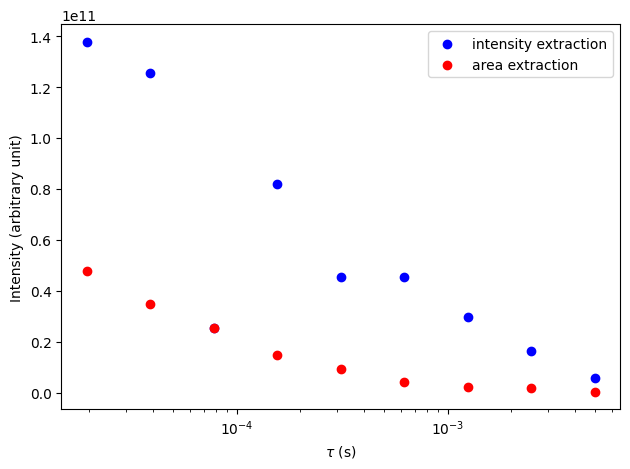

In [30]:
fig, ax = plt.subplots()

ax.scatter(vd_list, abs_ints, color='blue', label='intensity extraction')


ax.scatter(vd_list, simps_ints, color='red', label='area extraction')
# ax.errorbar(vd_list, simps_ints, yerr=int_uncs, fmt='o', color='red', label='error')

# ax.semilogy()

ax.semilogx()

ax.legend(loc='best', frameon=True)

ax.set_xlabel(r'$\tau$ (s)')
ax.set_ylabel('Intensity (arbitrary unit)')



plt.tight_layout()

plt.show()

## Single exponential fitting

T1_simps_area: 0.00010217635214086735 ± 2.1174008518649647e-05
A_simps_area: 1604701008.464661 ± 2.355204036413354e+16
B_simps_area: 31.574675822333777 ± 463975120.531155
C_simps_area: 2999344350.029867 ± 1426611309.6305165


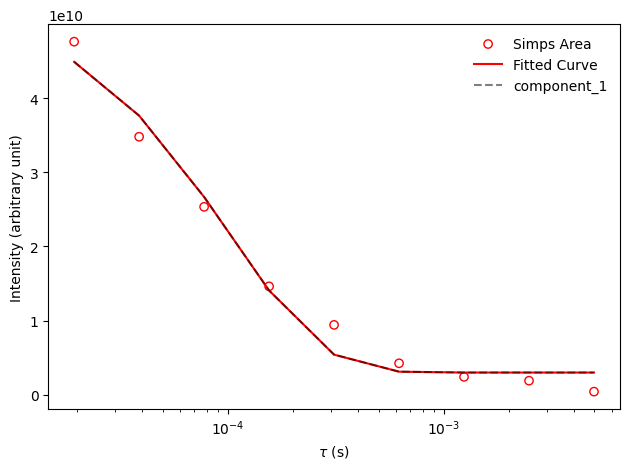

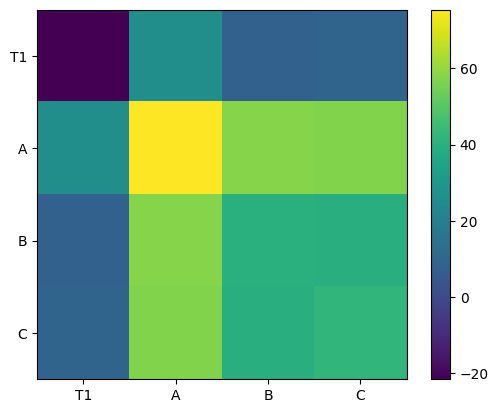

In [31]:
#T1rho fitting

fig, ax = plt.subplots()
output_lines = []
# Define a list of tuples for the two sets of intensities
intensity_sets = [
    (simps_ints, 'Simps Area', 'Guess Curve', 'Fitted Curve', 'r'),
    (abs_ints, 'Absolute Intensities', 'Guess Abs Int Curve', 'Fitted Curve Absolute Intensity', 'b')
]


# Initial guess parameters

T1_guess = 10.6 * 10**-3





for i, (ints, label, guess_label, fitted_label, color) in enumerate(intensity_sets):
    if i ==0:
        # A_guess = np.max(ints)
        A_guess = 747197159
        
        B_guess = 43
        
        C_guess = np.min(ints)
        
        
    
    # Scatter plot
        # ax.scatter(vd_list, ints, color=color, label=label)
    #scatter plot with marker having no face color
        ax.scatter(vd_list, ints, color=color, marker='o', facecolors='none', label=label)
    
    # Guess curve
        guess_integrated_int = t1.mono_expdec(vd_list, T1_guess, A_guess, B_guess, C_guess)
        # guess_integrated_int = t1.expdec(vd_list, T1_guess, T2_guess, T3_guess, A_guess, B_guess)
        
        # ax.plot(vd_list, guess_integrated_int, color='brown', linestyle='--', label=guess_label, alpha=0.9)
    
    # Fit the data
        popt, pcov = curve_fit(t1.mono_expdec, vd_list, ints, p0=[T1_guess, A_guess, B_guess, C_guess])
    
    # Save the fitted params and uncertainties
        T1_fitted, A_fitted, B_fitted, C_fitted = popt
        T1_unc, A_unc, B_unc, C_unc = np.sqrt(np.diag(pcov))
        
        #define T1 and T2
        component_1 = A_fitted *  (B_fitted)*np.exp(-vd_list/T1_fitted) + C_fitted
        

    
    # Extract the fitted curve
    
        fitted_curve = t1.mono_expdec(vd_list,T1_fitted, A_fitted, B_fitted, C_fitted)
        ax.plot(vd_list, fitted_curve, linestyle='-', color=color, label=fitted_label)
        # ax.scatter(vd_list, fitted_curve, color='black', marker='o', facecolors='none', label=fitted_label)
        ax.plot(vd_list, component_1, linestyle='--', color='black', alpha=0.5, label='component_1')

      

    
    # print the fitted parameters and uncertainties
        print(f'T1_{label.lower().replace(" ", "_")}: {T1_fitted} ± {T1_unc}')
     
    
        print(f'A_{label.lower().replace(" ", "_")}: {A_fitted} ± {A_unc}')
        print(f'B_{label.lower().replace(" ", "_")}: {B_fitted} ± {B_unc}')
        print(f'C_{label.lower().replace(" ", "_")}: {C_fitted} ± {C_unc}')

    
    # #Format the string and append fitted parameters
        
        output_lines.append(f'M0_{label.lower().replace(" ", "_")}: {A_fitted} ± {A_unc}\n')
        output_lines.append(f'T1_{label.lower().replace(" ", "_")}: {T1_fitted} ± {T1_unc}\n')

 
        output_lines.append(f'B_{label.lower().replace(" ", "_")}: {B_fitted} ± {B_unc}\n')
        output_lines.append(f'C_{label.lower().replace(" ", "_")}: {C_fitted} ± {C_unc}\n')
       
        #save the fitted params and uncertainties in a text file
        with open(filepath+'mono_exp_fitted_params.txt', 'w') as f:
            f.writelines(output_lines)


# ax.semilogy()
ax.semilogx()
ax.legend(loc='best', frameon=False)
ax.set_xlabel(r'$\tau$ (s)')
ax.set_ylabel('Intensity (arbitrary unit)')


#plot the covariance matrix in another figure and label the axes with the fitted parameters


plt.savefig(filepath+'mono_exp_T1_fitting.svg', bbox_inches='tight', transparent=True)
plt.tight_layout()
fig, ax = plt.subplots()
im = ax.imshow(np.log(np.abs(pcov)))
ax.set_xticks(np.arange(len(popt)))
ax.set_yticks(np.arange(len(popt)))
ax.set_xticklabels(['T1', 'A', 'B', 'C'])
ax.set_yticklabels(['T1', 'A', 'B', 'C'])
plt.colorbar(im)
plt.show()
plt.clf()
plt.close()

From the fit above, it is evident that there is more than 1 T2 spin-spin relaxation time constant, so the relaxation curve will be fitted with two T2 components.

## Multiple exponential fitting

T1_simps_area: 0.0004946263985536798 ± 0.00020040283490398923
T2_simps_area: 4.848011749380796e-05 ± 1.9614511482538942e-05
A_simps_area: 3438254710.8369365 ± 2.804566531639265e+16
D_simps_area: 12.979705489998619 ± 106204644.62067372
C_simps_area: 5.1491745318078905 ± 42135028.85234811


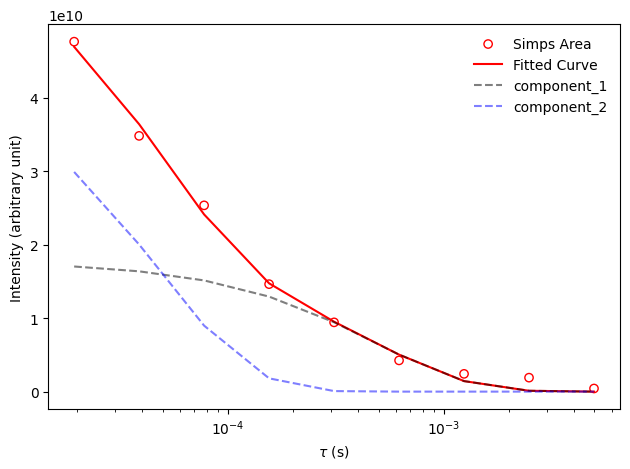

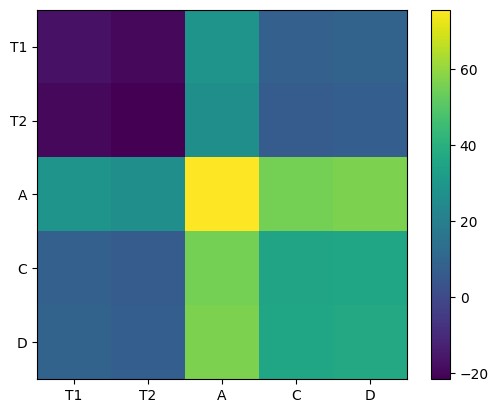

In [32]:
#T1rho fitting

fig, ax = plt.subplots()
output_lines = []
# Define a list of tuples for the two sets of intensities
intensity_sets = [
    (simps_ints, 'Simps Area', 'Guess Curve', 'Fitted Curve', 'r'),
    (abs_ints, 'Absolute Intensities', 'Guess Abs Int Curve', 'Fitted Curve Absolute Intensity', 'b')
]


# Initial guess parameters

T1_guess = 10.6 * 10**-3

T2_guess = 0.1 * 10**-3





for i, (ints, label, guess_label, fitted_label, color) in enumerate(intensity_sets):
    if i ==0:
        # A_guess = np.max(ints)
        A_guess = 747197159
        
        C_guess = 0.8
        
        D_guess = 0.2
        
        
    
    # Scatter plot
        # ax.scatter(vd_list, ints, color=color, label=label)
    #scatter plot with marker having no face color
        ax.scatter(vd_list, ints, color=color, marker='o', facecolors='none', label=label)
    
    # Guess curve
        guess_integrated_int = t1.di_expdec(vd_list, T1_guess, T2_guess, A_guess, C_guess, D_guess)
        # guess_integrated_int = t1.expdec(vd_list, T1_guess, T2_guess, T3_guess, A_guess, B_guess)
        
        # ax.plot(vd_list, guess_integrated_int, color='brown', linestyle='--', label=guess_label, alpha=0.9)
    
    # Fit the data
        popt, pcov = curve_fit(t1.di_expdec, vd_list, ints, p0=[T1_guess,T2_guess, A_guess, C_guess, D_guess])
    
    # Save the fitted params and uncertainties
        T1_fitted, T2_fitted, A_fitted, C_fitted, D_fitted = popt
        T1_unc, T2_unc, A_unc, C_unc, D_unc = np.sqrt(np.diag(pcov))
        
        #define T1 and T2
        component_1 = A_fitted *  (C_fitted)*np.exp(-vd_list/T1_fitted)
        
        component_2 = A_fitted *  (D_fitted)*np.exp(-vd_list/T2_fitted)
        

    
    # Extract the fitted curve
    
        fitted_curve = t1.di_expdec(vd_list,T1_fitted, T2_fitted, A_fitted, C_fitted, D_fitted)
        ax.plot(vd_list, fitted_curve, linestyle='-', color=color, label=fitted_label)
        # ax.scatter(vd_list, fitted_curve, color='black', marker='o', facecolors='none', label=fitted_label)
        ax.plot(vd_list, component_1, linestyle='--', color='black', alpha=0.5, label='component_1')
        ax.plot(vd_list, component_2, linestyle='--', color='blue', alpha=0.5, label='component_2')

      

    
    # print the fitted parameters and uncertainties
        print(f'T1_{label.lower().replace(" ", "_")}: {T1_fitted} ± {T1_unc}')
        print(f'T2_{label.lower().replace(" ", "_")}: {T2_fitted} ± {T2_unc}')
        
     
    
        print(f'A_{label.lower().replace(" ", "_")}: {A_fitted} ± {A_unc}')
        print(f'D_{label.lower().replace(" ", "_")}: {D_fitted} ± {D_unc}')
        print(f'C_{label.lower().replace(" ", "_")}: {C_fitted} ± {C_unc}')

    
    # #Format the string and append fitted parameters
        
        output_lines.append(f'M0_{label.lower().replace(" ", "_")}: {A_fitted} ± {A_unc}\n')
        output_lines.append(f'T1_{label.lower().replace(" ", "_")}: {T1_fitted} ± {T1_unc}\n')
        output_lines.append(f'T2_{label.lower().replace(" ", "_")}: {T2_fitted} ± {T2_unc}\n')
        

 
        output_lines.append(f'D_{label.lower().replace(" ", "_")}: {D_fitted} ± {D_unc}\n')
        output_lines.append(f'C_{label.lower().replace(" ", "_")}: {C_fitted} ± {C_unc}\n')
       
        #save the fitted params and uncertainties in a text file
        with open(filepath+'di_exp_fitted_params.txt', 'w') as f:
            f.writelines(output_lines)


# ax.semilogy()
ax.semilogx()
ax.legend(loc='best', frameon=False)
ax.set_xlabel(r'$\tau$ (s)')
ax.set_ylabel('Intensity (arbitrary unit)')


#plot the covariance matrix in another figure and label the axes with the fitted parameters


plt.savefig(filepath+'di_exp_T1_fitting.svg', bbox_inches='tight', transparent=True)
plt.tight_layout()
fig, ax = plt.subplots()
im = ax.imshow(np.log(np.abs(pcov)))
ax.set_xticks(np.arange(len(popt)))
ax.set_yticks(np.arange(len(popt)))
ax.set_xticklabels(['T1', 'T2', 'A', 'C', 'D'])
ax.set_yticklabels(['T1', 'T2', 'A', 'C', 'D'])
plt.colorbar(im)
plt.show()
plt.clf()
plt.close()

The nucleus studied here is <sup>7</sup>Li and the diffusing Li species have almost similar relaxation times, which is evident from the T2 relaxation time constants and the covariance matrix plot.